## [Credit](https://blog.varunajayasiri.com/numpy_lstm.html)
在此做了汉化，并将forward和backward中的代码，对应到本课程中梯度推导，方便大家对应。

In [ ]:
import numpy as np
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from IPython import display
plt.style.use('seaborn-white')
np.random.seed(42)

### 读取数据

In [ ]:
# !wget http://cs.stanford.edu/people/karpathy/char-rnn/shakespear.txt
data = open('shakespear.txt', 'r').read()

预处理

In [ ]:
chars = list(set(data))
data_size, X_size = len(data), len(chars)
print("data has %d characters, %d unique" % (data_size, X_size))
char_to_idx = {ch:i for i,ch in enumerate(chars)}
idx_to_char = {i:ch for i,ch in enumerate(chars)}

data has 99993 characters, 62 unique


### 常量和超参数设置

In [ ]:
H_size = 100 # 隐层维数
T_steps = 25 # 训练的序列长度
learning_rate = 1e-1 # 学习率
weight_sd = 0.1 # 初始化参数时的采样分布的标准差
z_size = H_size + X_size # 拼接h_{t-1} 和 x_{t} 后的维度

### 激活函数及梯度

#### Sigmoid

\begin{align}
\sigma(x) &= \frac{1}{1 + e^{-x}}\\
\frac{d\sigma(x)}{dx} &= \sigma(x) \cdot (1 - \sigma(x))
\end{align}

#### Tanh

\begin{align}
\frac{d\text{tanh}(x)}{dx} &= 1 - \text{tanh}^2(x)
\end{align}

In [ ]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))


def dsigmoid(y):
    return y * (1 - y)


def tanh(x):
    return np.tanh(x)


def dtanh(y):
    return 1 - y * y

### 封装参数的信息，包括该参数名称、参数值、梯度和AdaGrad优化时需要累计的参数动量


In [ ]:
class Param:
    def __init__(self, name, value):
        self.name = name
        self.v = value #parameter value
        self.d = np.zeros_like(value) #derivative
        self.m = np.zeros_like(value) #momentum for AdaGrad

利用正太分布初始化参数，对经$tanh$激活函数的参数使用正态分布 (`0`, `weight_sd`)，对经$sigmoid$激活函数的参数使用正态分布 (`0.5`, `weight_sd`)作初始胡，bias初始化为0。

In [ ]:
class Parameters:
    def __init__(self):
        self.W_f = Param('W_f', 
                         np.random.randn(H_size, z_size) * weight_sd + 0.5)
        self.b_f = Param('b_f',
                         np.zeros((H_size, 1)))

        self.W_i = Param('W_i',
                         np.random.randn(H_size, z_size) * weight_sd + 0.5)
        self.b_i = Param('b_i',
                         np.zeros((H_size, 1)))

        self.W_C = Param('W_C',
                         np.random.randn(H_size, z_size) * weight_sd)
        self.b_C = Param('b_C',
                         np.zeros((H_size, 1)))

        self.W_o = Param('W_o',
                         np.random.randn(H_size, z_size) * weight_sd + 0.5)
        self.b_o = Param('b_o',
                         np.zeros((H_size, 1)))

        #最后一层用于预测t-时刻的标签/字
        self.W_v = Param('W_v',
                         np.random.randn(X_size, H_size) * weight_sd)
        self.b_v = Param('b_v',
                         np.zeros((X_size, 1)))
        
    def all(self):
        return [self.W_f, self.W_i, self.W_C, self.W_o, self.W_v,
               self.b_f, self.b_i, self.b_C, self.b_o, self.b_v]
        
parameters = Parameters()

### t 时刻前向运算


In [ ]:
def forward(x, h_prev, C_prev, p = parameters):
    assert x.shape == (X_size, 1)
    assert h_prev.shape == (H_size, 1)
    assert C_prev.shape == (H_size, 1)
    
    # 拼接h_t-1 和 x_t
    z = np.row_stack((h_prev, x))

    # 计算忘记、输入和输出门
    f = sigmoid(p.W_f.v @ z + p.b_f.v)
    i = sigmoid(p.W_i.v @ z + p.b_i.v)
    o = sigmoid(p.W_o.v @ z + p.b_o.v)

    # 计算pre-cell输入
    C_bar = tanh(p.W_C.v @ z + p.b_C.v)

    # 计算cell输入
    C = f * C_prev + i * C_bar
    
    # 计算隐状态
    h = o * tanh(C)

    # 计算t时刻输出
    v = p.W_v.v @ h + p.b_v.v
    y = np.exp(v) / np.sum(np.exp(v)) #softmax

    return z, f, i, C_bar, C, o, h, v, y

### 梯度反向传播

#### 假设为CrossEntropy loss

\begin{align}
L_k &= -\sum_{t=k}^T\sum_j y_{t,j} log \hat{y_{t,j}} \\
\end{align}

In [ ]:
def backward(target, dh_next, dC_next, C_prev,
             z, f, i, C_bar, C, o, h, v, y,
             p = parameters):
    
    assert z.shape == (X_size + H_size, 1)
    assert v.shape == (X_size, 1)
    assert y.shape == (X_size, 1)
    
    for param in [dh_next, dC_next, C_prev, f, i, C_bar, C, o, h]:
        assert param.shape == (H_size, 1)
        
    # LSTM t时刻损失函数对v梯度
    dv = np.copy(y)
    dv[target] -= 1

    # 隐状态梯度
    dh = p.W_v.v.T @ dv + dh_next

    # 输出门梯度
    do = dh * tanh(C)
    # 输出门激活前梯度
    da_o = dsigmoid(o) * do

    # cell梯度
    dC = dC_next + dh * o * dtanh(tanh(C))
    # cell输入梯度
    dC_bar = dC * i
    # cell输入激活前梯度
    da_c = dtanh(C_bar) * dC_bar

    # 输入门梯度
    di = dC * C_bar
    # 输入门激活前梯度
    da_i = dsigmoid(i) * di

    # 上一时刻cell梯度
    dC_prev = f * dC

    # 忘记门梯度
    df = dC * C_prev
    # 忘记门激活前梯度
    da_f = dsigmoid(f) * df

    # z梯度
    dz = (p.W_f.v.T @ da_f
      + p.W_i.v.T @ da_i
      + p.W_C.v.T @ da_c
      + p.W_o.v.T @ da_o)
    
    ###################
    ## 计算各参数梯度 ##
    ###################

    # LSTM Cell外输出层参数    
    p.W_v.d += (dv @ h.T)
    p.b_v.d += dv
    
    # 输出门参数
    p.W_o.d += da_o @ z.T
    p.b_o.d += da_o
    # cell输入
    p.W_C.d += da_c @ z.T
    p.b_C.d += da_c
    # 输入门参数
    p.W_i.d += da_i @ z.T
    p.b_i.d += da_i
    # 忘记门参数
    p.W_f.d += da_f @ z.T
    p.b_f.d += da_f

    # 从dz中截取h_{t-1}的梯度
    dh_prev = dz[:H_size, :]
    
    return dh_prev, dC_prev 

### 从单个时刻LSTM cell 到序列上的前向计算和梯度反向传播

清空梯度（类似pytorch中的 optim.zero_gradient()）

In [ ]:
def clear_gradients(params = parameters):
    for p in params.all():
        p.d.fill(0)

梯度裁剪操作，简单粗暴的抑制梯度爆炸的trick

In [ ]:
def clip_gradients(params = parameters):
    for p in params.all():
        np.clip(p.d, -1, 1, out=p.d)

计算和存储前向运算的结果. 在反向传播过程中，由T到1计算梯度并利用梯度裁剪抑制梯度爆炸问题。

* `input`, `target` 都是字符的index
* `h_prev` 是0时刻的隐状态初始值，即$h_{-1}$时的`h`，(size H x 1)
* `C_prev` 是0时刻cell的初始值，即$C_{-1}$时的`C` (size H x 1)
* *Returns* loss, 最后时刻的隐状态和cell： $h_T$ and $C_T$

In [ ]:
def forward_backward(inputs, targets, h_prev, C_prev):
    global paramters
    
    # 存储每一时刻的前向计算结果
    x_s, z_s, f_s, i_s,  = {}, {}, {}, {}
    C_bar_s, C_s, o_s, h_s = {}, {}, {}, {}
    v_s, y_s =  {}, {}
    
    # 初始化t=0时的前隐状态和cell值
    h_s[-1] = np.copy(h_prev)
    C_s[-1] = np.copy(C_prev)
    
    loss = 0
    # 循环序列中的每一个step
    assert len(inputs) == T_steps
    for t in range(len(inputs)):
        x_s[t] = np.zeros((X_size, 1))
        x_s[t][inputs[t]] = 1 # 输入字符的one-hot编码向量
        
        (z_s[t], f_s[t], i_s[t],
        C_bar_s[t], C_s[t], o_s[t], h_s[t],
        v_s[t], y_s[t]) = \
            forward(x_s[t], h_s[t - 1], C_s[t - 1]) # 前向计算
            
        loss += -np.log(y_s[t][targets[t], 0]) # 累加每个时刻的损失
        
    clear_gradients()

    dh_next = np.zeros_like(h_s[0]) #dh 下一时刻的隐状态梯度
    dC_next = np.zeros_like(C_s[0]) #dh 下一时刻的cell梯度

    for t in reversed(range(len(inputs))):
        # 梯度反向传播
        dh_next, dC_next = \
            backward(target = targets[t], dh_next = dh_next,
                     dC_next = dC_next, C_prev = C_s[t-1],
                     z = z_s[t], f = f_s[t], i = i_s[t], C_bar = C_bar_s[t],
                     C = C_s[t], o = o_s[t], h = h_s[t], v = v_s[t],
                     y = y_s[t])

    clip_gradients()
        
    return loss, h_s[len(inputs) - 1], C_s[len(inputs) - 1]

### 给定模型采样字符序列



In [ ]:
def sample(h_prev, C_prev, first_char_idx, sentence_length):
    x = np.zeros((X_size, 1))
    x[first_char_idx] = 1

    h = h_prev
    C = C_prev

    indexes = []
    
    for t in range(sentence_length):
        _, _, _, _, C, _, h, _, p = forward(x, h, C)
        idx = np.random.choice(range(X_size), p=p.ravel())
        x = np.zeros((X_size, 1))
        x[idx] = 1
        indexes.append(idx)

    return indexes

## Training (Adagrad)

# 训练中的打印信息，损失函数及下降曲线

In [ ]:
def update_status(inputs, h_prev, C_prev):
    #声明为全局变量，在后续初始化
    global plot_iter, plot_loss
    global smooth_loss
    
    # 用当前模型预测200个字符

    sample_idx = sample(h_prev, C_prev, inputs[0], 200)
    txt = ''.join(idx_to_char[idx] for idx in sample_idx)

    # 显示图片
    plt.plot(plot_iter, plot_loss)
    display.clear_output(wait=True)
    plt.show()

    # 输出预测和损失
    print("----\n %s \n----" % (txt, ))
    print("iter %d, loss %f" % (iteration, smooth_loss))

利用 AdaGrad 跟新参数

\begin{align}
\theta_i &= \theta_i - \eta\frac{d\theta_i}{\sum dw_{\tau}^2} \\
d\theta_i &= \frac{\partial L}{\partial \theta_i}
\end{align}

In [ ]:
def update_paramters(params = parameters):
    for p in params.all():
        p.m += p.d * p.d # 计算梯度平方的累积量（用于AdaGrad计算每一步梯度下降对每一个参数的更新量）
        #print(learning_rate * dparam)
        p.v += -(learning_rate * p.d / np.sqrt(p.m + 1e-8))

延时终止信号的处理, 防止训练意外终止。

In [ ]:
import signal

class DelayedKeyboardInterrupt(object):
    def __enter__(self):
        self.signal_received = False
        self.old_handler = signal.signal(signal.SIGINT, self.handler)

    def handler(self, sig, frame):
        self.signal_received = (sig, frame)
        print('SIGINT received. Delaying KeyboardInterrupt.')

    def __exit__(self, type, value, traceback):
        signal.signal(signal.SIGINT, self.old_handler)
        if self.signal_received:
            self.old_handler(*self.signal_received)

In [ ]:
# 对损失函数求指数平均
# 初始化为一个随机模型的损失
smooth_loss = -np.log(1.0 / X_size) * T_steps

iteration, pointer = 0, 0

# 绘图用参数初始化
plot_iter = np.zeros((0))
plot_loss = np.zeros((0))

训练循环

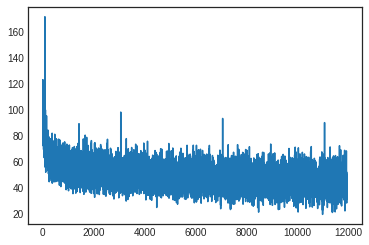

----
 nley. I fence heas badt tiqles, my lord: and siven heads.

DARV ANTONY:
A full me have gonched soo and go
doss.

CAVFILI:
Say! what main, sele fall seiven liods quring Bithang
-iement daanbess
To this 
----
iter 11945, loss 44.492210


In [ ]:
n_epoches = 10000
while n_epoches:
    try:
        with DelayedKeyboardInterrupt():
            # 重置变量
            if pointer + T_steps >= len(data) or iteration == 0:
                g_h_prev = np.zeros((H_size, 1))
                g_C_prev = np.zeros((H_size, 1))
                pointer = 0
                n_epoches -= 1


            inputs = ([char_to_idx[ch] 
                       for ch in data[pointer: pointer + T_steps]])
            targets = ([char_to_idx[ch] 
                        for ch in data[pointer + 1: pointer + T_steps + 1]])

            loss, g_h_prev, g_C_prev = \
                forward_backward(inputs, targets, g_h_prev, g_C_prev)
            smooth_loss = smooth_loss * 0.999 + loss * 0.001

            # 每一百次输出训练信息
            if iteration % 100 == 0:
                update_status(inputs, g_h_prev, g_C_prev)

            update_paramters()

            plot_iter = np.append(plot_iter, [iteration])
            plot_loss = np.append(plot_loss, [loss])

            pointer += T_steps
            iteration += 1
    except KeyboardInterrupt:
        update_status(inputs, g_h_prev, g_C_prev)
        break

### 梯度检查

通过数值计算得到梯度的近似值，和由反向传播得到的梯度比较。
对每一个参数向量或矩阵，随机选择`num_checks`个参数做检测。

In [ ]:
from random import uniform

计算数值梯度

In [ ]:
def calc_numerical_gradient(param, idx, delta, inputs, target, h_prev, C_prev):
    old_val = param.v.flat[idx]
    
    # 计算 [x + delta] 和 [x - delta]处的损失
    param.v.flat[idx] = old_val + delta
    loss_plus_delta, _, _ = forward_backward(inputs, targets,
                                             h_prev, C_prev)
    param.v.flat[idx] = old_val - delta
    loss_mins_delta, _, _ = forward_backward(inputs, targets, 
                                             h_prev, C_prev)
    
    param.v.flat[idx] = old_val #reset

    grad_numerical = (loss_plus_delta - loss_mins_delta) / (2 * delta)
    
    # 同样需要对计算得到的梯度进行裁剪，因为我们的实现中对分析解也做了梯度裁剪
    [grad_numerical] = np.clip([grad_numerical], -1, 1) 
    
    return grad_numerical

对所有参数向量或矩阵，随机选取 `num_checks`个参数检查梯度

In [ ]:
def gradient_check(num_checks, delta, inputs, target, h_prev, C_prev):
    global parameters
    
    # 获取得到的梯度
    _, _, _ =  forward_backward(inputs, targets, h_prev, C_prev)
    
    
    for param in parameters.all():
        # 复制一份梯度，因为检查时会被改变
        d_copy = np.copy(param.d)

        # 随机选出num_checks个参数做检查
        for i in range(num_checks):
            # 随机选择一个参数
            rnd_idx = int(uniform(0, param.v.size))
            
            grad_numerical = calc_numerical_gradient(param,
                                                     rnd_idx,
                                                     delta,
                                                     inputs,
                                                     target,
                                                     h_prev, C_prev)
            grad_analytical = d_copy.flat[rnd_idx]

            err_sum = abs(grad_numerical + grad_analytical) + 1e-09
            rel_error = abs(grad_analytical - grad_numerical) / err_sum
            
            # 如果相对误差超过 1e-06，打印结果人工查看
            if rel_error > 1e-06:
                print('%s (%e, %e) => %e'
                      % (param.name, grad_numerical, grad_analytical, rel_error))

In [ ]:
gradient_check(10, 1e-5, inputs, targets, g_h_prev, g_C_prev)

W_f (-1.320117e-05, -1.320242e-05) => 4.736269e-05
W_o (-4.603418e-04, -4.603502e-04) => 9.088534e-06
W_o (-2.541084e-03, -2.541078e-03) => 1.182117e-06
b_i (1.963908e-03, 1.963915e-03) => 1.921144e-06
b_C (-2.212443e-02, -2.212466e-02) => 5.262875e-06
b_o (-3.218299e-02, -3.218287e-02) => 1.924774e-06
b_o (-2.110184e-02, -2.110179e-02) => 1.358245e-06
b_o (-1.945691e-02, -1.945680e-02) => 2.841330e-06
